## Importo librerias

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import os
import glob
import tensorflow as tf

from PIL import Image
import cv2
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from tensorflow.keras import layers
import keras
from keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

import tqdm

In [2]:
actual = os. getcwd()

In [3]:
breed_path = actual + "/Dogs/"

In [4]:
train_paths = []
test_paths = []

for breed in os.listdir(breed_path):
    if not "Test" in breed:
        train_paths.append(f"{breed_path}/{breed}")
    else:
        test_paths.append(f"{breed_path}/{breed}")

## Obtengo imagenes de testeo

In [5]:
X_test = []
y_test = []


for test_path in test_paths:
    breed = test_path.split("/")[-1].split("_")[0]
    images_name = os.listdir(test_path)

    for image in images_name:
        images_path = f"{test_path}/{image}"
        image = cv2.imread(filename = images_path)
        imgage_rgb = cv2.cvtColor(src = image, code = cv2.COLOR_BGR2RGB)
        X_test.append(imgage_rgb)
        y_test.append(breed)

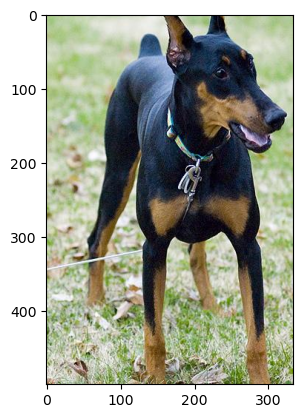

In [6]:
plt.imshow(X_test[3])

## Obtengo imagenes de entrenamiento

In [7]:
X_train = []
y_train = []


for train_path in train_paths:
    breed = train_path.split("/")[-1]
    images_name = os.listdir(train_path)

    for image in images_name:
        images_path = f"{train_path}/{image}"
        image = cv2.imread(filename = images_path)
        imgage_rgb = cv2.cvtColor(src = image, code = cv2.COLOR_BGR2RGB)
        X_train.append(imgage_rgb)
        y_train.append(breed)

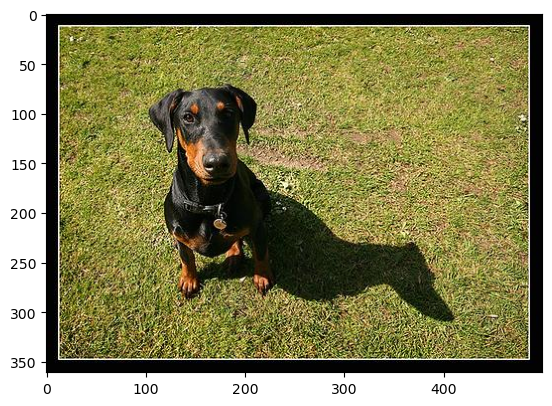

In [8]:
plt.imshow(X_train[3])

In [9]:
print(len(X_train))
print(len(y_train))

400
400


# Exploro las imagenes para cada raza

## Procesamiento de imagenes

### Obtengo dimensiones medias de las imagenes

In [10]:
media_alto = int(np.mean([dim.shape[0] for dim in X_train]))
media_ancho = int(np.mean([dim.shape[1] for dim in X_train]))
print(media_alto)
print(media_ancho)

404
452


## Procesamiento de imagenes

Tomaremos para las imagenes un tamaño de 224x224.



*   X Data



In [11]:
def image_processor(images, high, width):
    images_processed = []

    for image in images:
        image_processed = image / 255
        image_resized = cv2.resize(src = image_processed, dsize = (high, width))
        images_processed.append(image_resized)

    return images_processed

In [12]:
X_train_processed = np.array(image_processor(X_train, 224, 224))
X_test_processed = np.array(image_processor(X_test, 224, 224))

In [13]:
len(X_train_processed)

400



*   y Data



In [14]:
dic_classes = {clase: idx for idx, clase in enumerate(np.unique(y_train))}

In [15]:
y_train_processed = pd.Series(y_train).map(dic_classes)
y_test_processed = pd.Series(y_test).map(dic_classes)

In [17]:
y_train_processed.head(3)

0    0
1    0
2    0
dtype: int64

## Data Augmentation

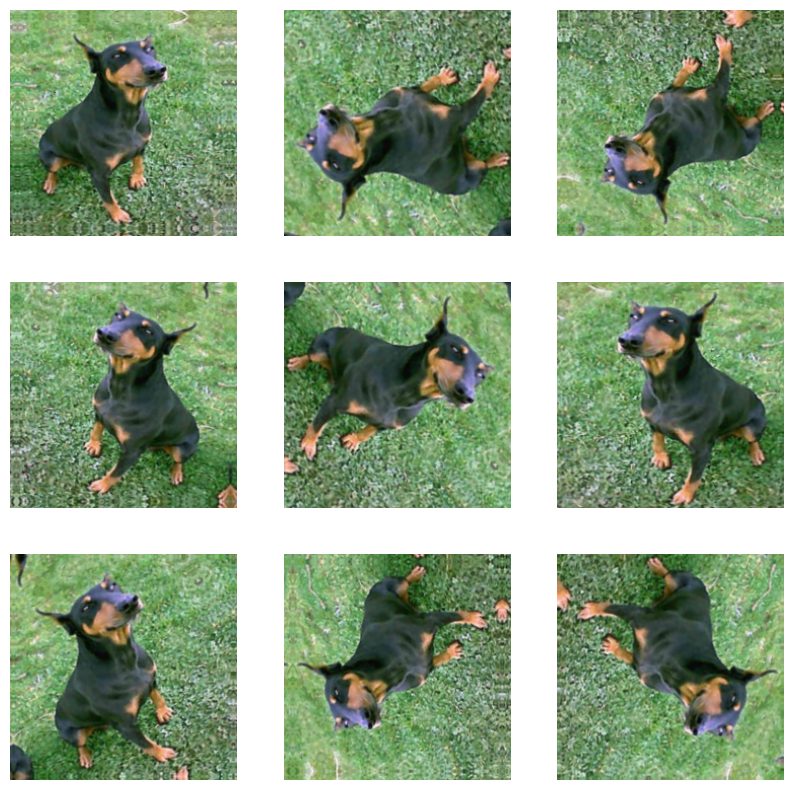

In [18]:
data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.2), layers.experimental.preprocessing.RandomZoom(0.1)])

image_augme = X_train_processed[0]
image = tf.expand_dims(image_augme, 0)
plt.figure(figsize=(10, 10))

new_images = []
for i in range(9):

    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    new_images.append(augmented_image[0])
    plt.axis("off")

In [20]:
data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.2), layers.experimental.preprocessing.RandomZoom(0.1)])

X_train_aug = []
y_train_aug = []

for image, breed in tqdm.tqdm(zip(X_train_processed, y_train_processed)):

    img = tf.expand_dims(image, 0)
    for i in range(9):

        augmented_image = data_augmentation(img)
        X_train_aug.append(augmented_image[0])
        y_train_aug.append(breed)

400it [01:45,  3.80it/s]


In [21]:
print("X_train")
print(len(X_train_aug))
print(type(X_train_aug))

print("-----------------------")

print("y_train")
print(len(y_train_aug))
print(type(y_train_aug))

X_train
3600
<class 'list'>
-----------------------
y_train
3600
<class 'list'>


## Data preparation



*   Train set



In [22]:
X_train_aug = np.array(X_train_aug)
y_train_aug = to_categorical(y_train_aug)

In [23]:
# Suffle
randomize_train = np.arange(len(y_train_aug))
np.random.shuffle(randomize_train)
X_train_random = X_train_aug[randomize_train]
y_train_random = y_train_aug[randomize_train]



*   Test set



In [24]:
y_test_processed = to_categorical(y_test_processed)

In [25]:
# Suffle
randomize_test = np.arange(len(y_test_processed))
np.random.shuffle(randomize_test)
X_test_random = X_test_processed[randomize_test]
y_test_random = y_test_processed[randomize_test]

## Neural Network

In [28]:
num_classes = len(dic_classes.keys())

# Inicializamos el modelo
model = Sequential()

# Capa de Entrada (Convolucion)
model.add(Conv2D(filters = 32, kernel_size = (5, 5), activation = "relu", input_shape = (452, 404, 3)))

# Pooling
model.add(MaxPooling2D(pool_size = (2, 2)))

# Convolucion
model.add(Conv2D(filters = 32, kernel_size = (5, 5), activation = "relu"))

# Pooling
model.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten (Las aplanamos para seguir con la red neuronal)
model.add(Flatten())

# Capas Ocultas
model.add(Dense(64, activation = "relu"))
model.add(Dense(64, activation = "relu"))

# Capa de Salida (Si es un problema de clasificación multiple siempre debe terminar con "softmax")
model.add(Dense(num_classes, activation = "softmax")) ## Para más de 2 clases se usa softmax

# Summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 448, 400, 32)      2432      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 224, 200, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 220, 196, 32)      25632     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 110, 98, 32)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 344960)            0         
                                                                 
 dense_3 (Dense)             (None, 64)               

## Fit our model

In [ ]:
model.compile(loss      = "categorical_crossentropy",
              optimizer = "adam",
              metrics   = ["accuracy"])

# Entrenamos el modelo
model.fit(x = X_train_random, y = y_train_random, validation_data = (X_test_random, y_test_random), batch_size = 32, epochs = 10)

In [ ]:
test_loss, test_acc = model.evaluate(X_test_random, y_test_random)

print("Test accuracy:", test_acc)

# Probar con una red preentrenada